## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

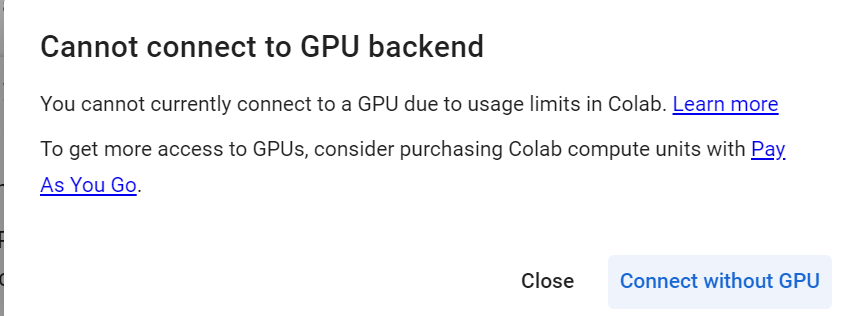

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 89.2 MB/s eta 0:00:00


In [ ]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To split data into train, test, validation
from sklearn.model_selection import train_test_split

# To use oversampling
from imblearn.over_sampling import SMOTE

# To build, tune, and evaluate ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Used in tokenization
from spacy.lang.en import English

# To import Word2Vec
from gensim.models import Word2Vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Format all numbers to two decimal places
pd.options.display.float_format = '{:.2f}'.format

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Loading the dataset**

In [ ]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_NLP/stock_news.csv")

In [ ]:
#Creating a copy of the dataset
stock = stock_news.copy()

## **Data Overview**

### View first 10 rows of the data

In [ ]:
stock.head(10)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.24,41.48,40.25,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.24,41.48,40.25,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.24,41.48,40.25,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.74,42.24,41.48,40.25,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.24,41.48,40.25,130672400,-1
5,2019-01-02,Apple CEO Tim Cook discussed the company's Q1 ...,41.74,42.24,41.48,40.25,130672400,0
6,2019-01-02,Roku Inc has announced plans to offer premium...,41.74,42.24,41.48,40.25,130672400,1
7,2019-01-02,Wall Street saw modest gains on Wednesday but...,41.74,42.24,41.48,40.25,130672400,-1
8,2019-01-02,Apple's fiscal first quarter revenue came in ...,41.74,42.24,41.48,40.25,130672400,-1
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.74,42.24,41.48,40.25,130672400,-1


### View 10 random rows of the data

In [ ]:
stock.sample(10)

,Date,News,Open,High,Low,Close,Volume,Label
134,2019-01-28,Apple reported spending over $60 billion with...,38.95,39.08,38.42,37.78,104768400,1
11,2019-01-02,"In early Asian trading on Thursday, the Japan...",41.74,42.24,41.48,40.25,130672400,-1
287,2019-04-02,Swatch Group successfully defended its use of...,41.85,42.92,41.82,41.39,125982000,0
188,2019-02-12,The U.K. government has released a report rec...,66.82,67.06,65.86,64.81,94487200,0
63,2019-01-08,"The Chinese smartphone market, the world's la...",53.47,54.51,51.69,50.79,216071600,0
112,2019-01-22,"The Swiss National Bank (SNB) governor, Andre...",39.10,39.18,38.15,37.05,121576000,-1
75,2019-01-10,"Cummins, Inc. (CMI) announced that Pat Ward, i...",56.27,57.05,56.05,54.93,139223200,0
141,2019-01-29,Corning defied the trend of weak results in t...,39.06,39.53,38.53,37.39,166348800,1
100,2019-01-15,Belarus unveiled its world-first regulated to...,37.57,38.35,37.51,37.00,114843600,1
215,2019-02-25,"Huawei, the world's third largest smartphone ...",43.54,43.97,43.49,42.29,87493600,1


### Shape of the data

In [ ]:
stock.shape

(349, 8)

The data consists of 349 rows and 8 columns.

### Data types and statistical summary of the data

In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


* The data has 8 columns. Open, High, Low and Close are numeric float values. Volume and Label are integer values. Date and News are object values. Date can be converted to DateTime format.

In [ ]:
stock['Date'] = pd.to_datetime(stock['Date'])

In [ ]:
stock.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,349,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
Open,349.00,46.23,37.57,41.74,45.97,50.71,66.82,6.44
High,349.00,46.70,37.82,42.24,46.03,50.85,67.06,6.51
Low,349.00,45.75,37.30,41.48,45.64,49.78,65.86,6.39
Close,349.00,44.93,36.25,40.25,44.60,49.11,64.81,6.40
Volume,349.00,128948236.10,45448000.00,103272000.00,115627200.00,151125200.00,244439200.00,43170314.92
Label,349.00,-0.05,-1.00,-1.00,0.00,0.00,1.00,0.72


* The range of the Dates in the data are from 2019-01-02 to 2019-04-30.
* Open, High, Low, Close all have a mean around 45-46, with very comparable first and third quartiles. On average Close seems to be slightly lower than Open. There are patterns and trends that the stock prices follow in this date range that are interesting to note. There is no unusually high or low stock prices on any given day.
* The volume of shares traded in a day ranges from 45 million to 244 million, on average of 128 million.
* Label is our sentiment indicator variable and values are -1, 0, 1 as expected. However, given that the mean is -0.05, there are likely much more neutral and negative label than positives ones.

### Checking for missing and duplicate values

In [ ]:
stock.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [ ]:
# checking for duplicate values
stock.duplicated().sum()

0

The data doesn't contain any missing or duplicate values.

## **Exploratory Data Analysis**

### Supporting functions

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content
* Explore price change % during the day

#### Label

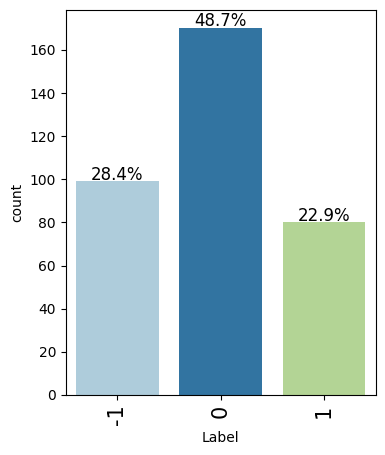

In [ ]:
labeled_barplot(stock, "Label", perc=True)

* Almost 50% of the news articles are neutral. About 28% of them are negative and 22% of them are positive.
* There is an imbalance in the data, with much more news articles being neutral. Though it isn't balanced, it is reflective of a real world scenario where more often than not, the news articles are neutral.

#### Open

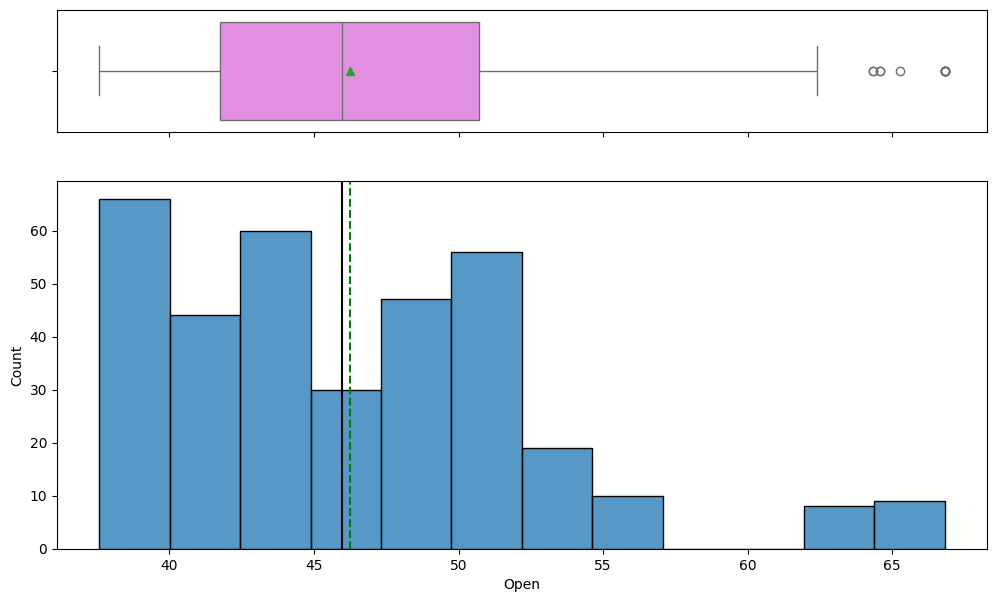

In [ ]:
histogram_boxplot(stock, "Open")

* The opening stock price at the beginning of the day fluctuates between about 37 to 67, but with a right skew. The mean and median are close to each other around 46.
* Values above 60 are outliers and are less likely to occur.
* 75% of the open stock prices are 50 or below.

#### High

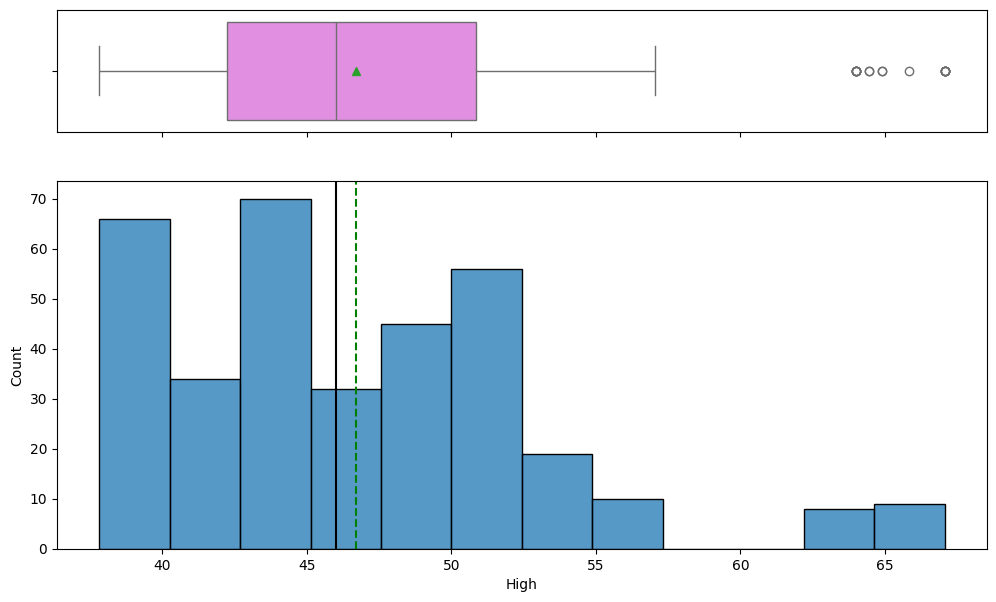

In [ ]:
histogram_boxplot(stock, "High")

* The distribution of High i.e. the highest stock price in the day is identical to that of Open.
* The highest stock price reached during the day is between about 37 to 67, but with a right skew. The mean and median are close to each other around 46.
* Values above 60 are outliers and are less likely to occur.
* 75% of the high stock prices are 50 or below.
* Given that High and Open are very similar, it is possible to deduce that there are no unusual high stock prices reached during the day and they stay relatively close to the opening stock price of the day.

#### Low

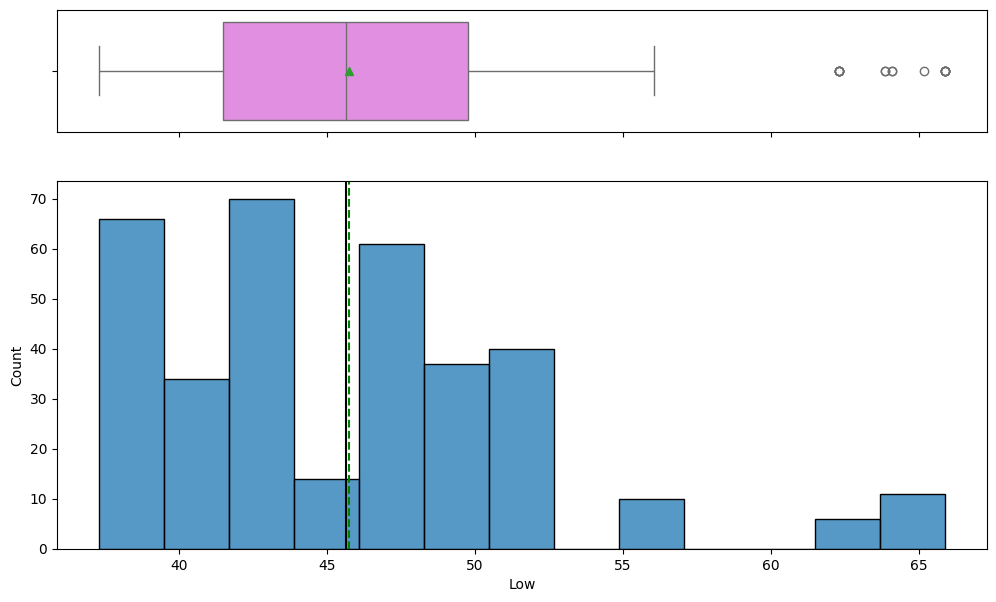

In [ ]:
histogram_boxplot(stock, "Low")

* The distribution of the lowest stock price in the day is right skewed, similar to Open and High with slight variations in the distribution but follows a very similar pattern.
* The mean and median lowest stock price is around 46.
* Though the distribution slightly varies, there are no unusually low stock price values which indicates stability.
* 75% of the low stock prices are 50 or below.

#### Close

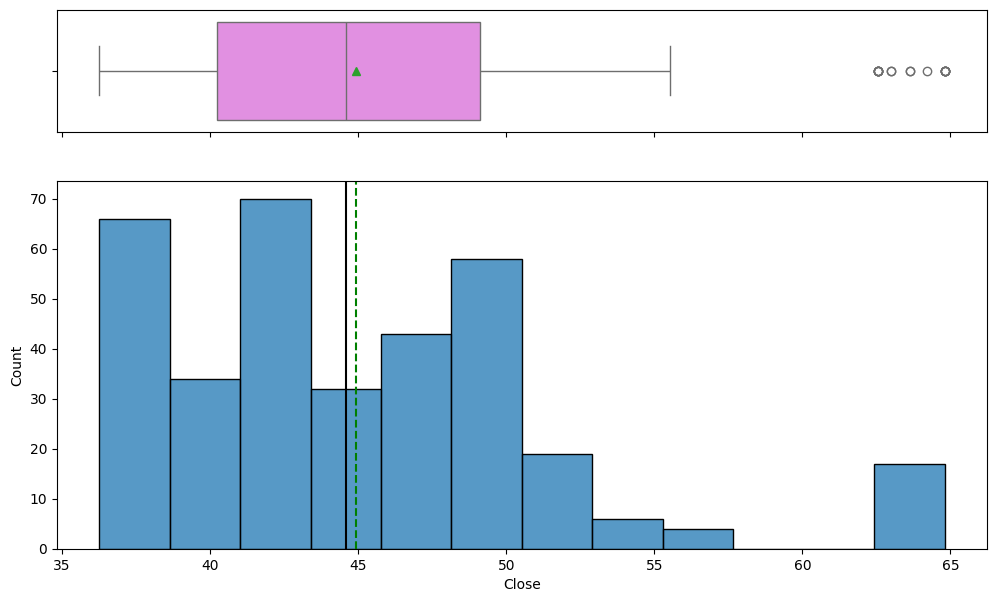

In [ ]:
histogram_boxplot(stock, "Close")

* The distribution of the closing stock price is right skewed, similar to Open, High, Low and has very identical mean and median.
* There are only a few outliers between 60 and 65, wheras the majority (75%) lie between 36 and 50.
* The lower limit of the distribution of closing price is slightly lower than open, high and low showing that the price at the end of the day is sometimes a little lower. However, it still maintains within the range and there are no unusually low or high closing price values.

#### News Length

In [ ]:
# Calculating the length of news articles from the news column, to convert it to a potentially useful numeric value
stock['news_length'] = stock['News'].apply(lambda x: len(x.split(' ')))

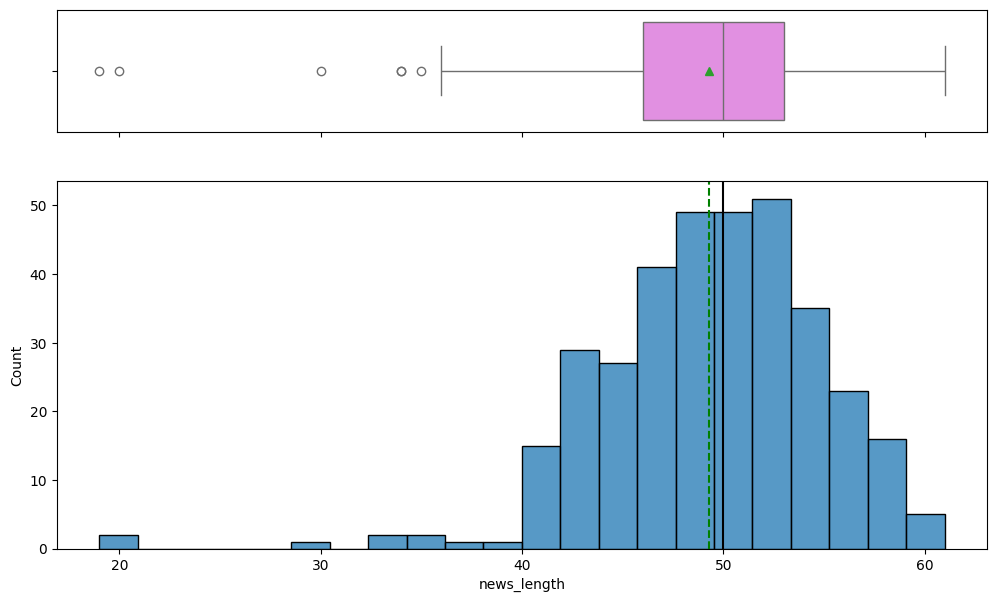

In [ ]:
histogram_boxplot(stock, "news_length")

* The distribution of news length in the data provided for the given weeks are left skewed.
* The mean and median news length is just below 50 words.
* The maximum news length is 60 and the lowest is 20. 75% of the news articles have length of 52 words or less.
* Very few news articles have 40 words or less.

#### Date

[Text(0.5, 1.0, 'Number of News Headlines per Date'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Count')]

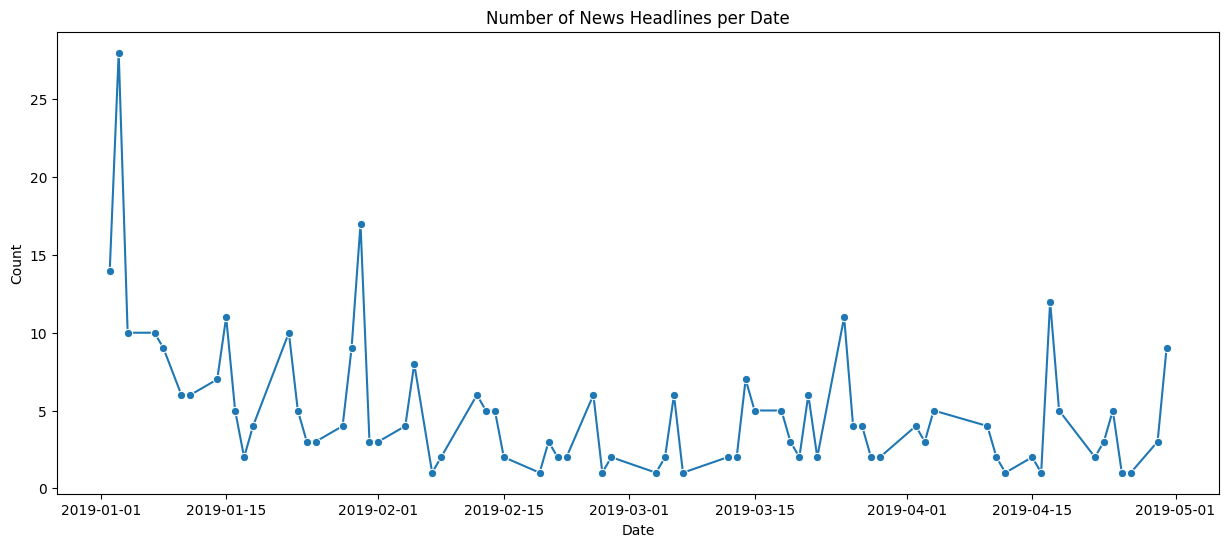

In [ ]:
# Time series plot to analyze how many news articles are present in each date.
plt.figure(figsize=(15, 6))
sns.lineplot(data=stock.groupby('Date').size().reset_index(name='count'), x='Date', y='count', marker='o') \
    .set(title='Number of News Headlines per Date', xlabel='Date', ylabel='Count')


* The dates range from 2019-01-01 to 2019-05-01 i.e. from January to March 2019.
* Most days have between 0 to 15 news articles. Except 1st January which has over 25 articles. This can be attributed to new year related events and news.

#### Price change %

In [ ]:
# Calculating the change in opening and closing price daily to analyze change in price with other variables.
stock['price_change_%'] = ((stock['Close'] - stock['Open']) / stock['Open']) * 100

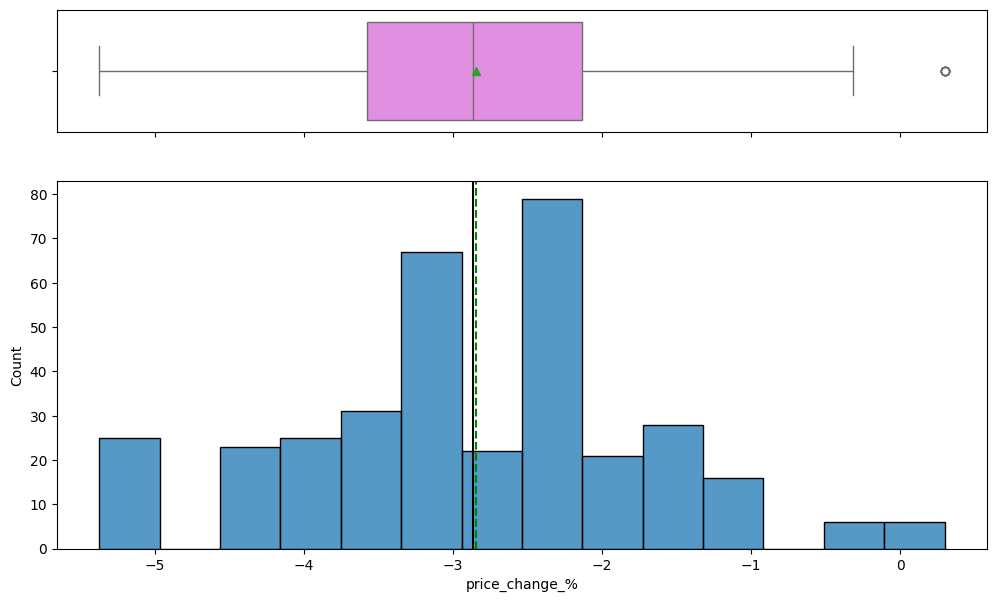

In [ ]:
histogram_boxplot(stock, "price_change_%")

* All the price change values are negative except one outlier which is positive. This indicates that the closing price is almost always lower than the opening price.
* The difference in price ranges from -5 to 0, which is a relatively small margin.
* 50% of the price ranges are between -2 and -3 per cent, which means that the price reduces and by very little. The mean and median price change % is about -3%.

### Bivariate Analysis



* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

#### Correlation

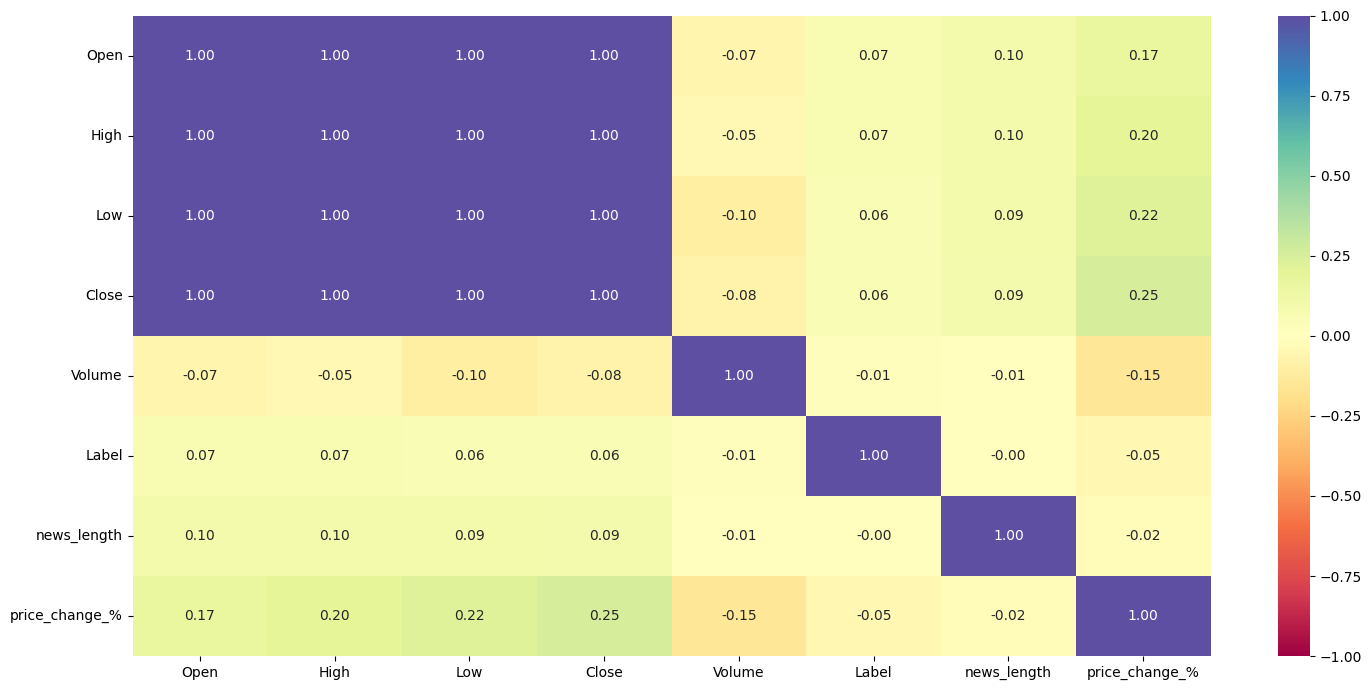

In [ ]:
cols_list = stock.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 7))
sns.heatmap(
    stock[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.tight_layout()
plt.show()

* The Open, High, Low, and Close prices have a perfect correlation (1.0) with each other. This suggests that these variables are interdependent and represent similar underlying trends.
* The price_change_% variable has a weak positive correlation with Open (0.17), High (0.20), Low (0.22), and Close (0.25). This indicates that the percentage change in price has some relationship with the stock prices but is not strongly influenced by them.
* The Volume (number of shares traded) has very weak or slightly negative correlations with Open (-0.07), High (-0.05), Low (-0.10), and Close (-0.08). This implies that trading volume does not have a significant direct relationship with stock prices.
* The Label (sentiment indicator) has weak positive correlations with Open (0.07), High (0.07), Low (0.06), and Close (0.06). This suggests that sentiment may have a slight impact on stock prices, but the effect is minimal.
* The news_length variable shows a weak positive correlation with Open (0.10), High (0.10), Low (0.09), and Close (0.09). This indicates that the length of news articles might slightly influence stock prices but is not a strong predictor.
* While each of the variabels are individually weak, together they may provide a better prediction but the initial analysis seems to indicate that this will be difficult with the variables available.

#### Label vs Price

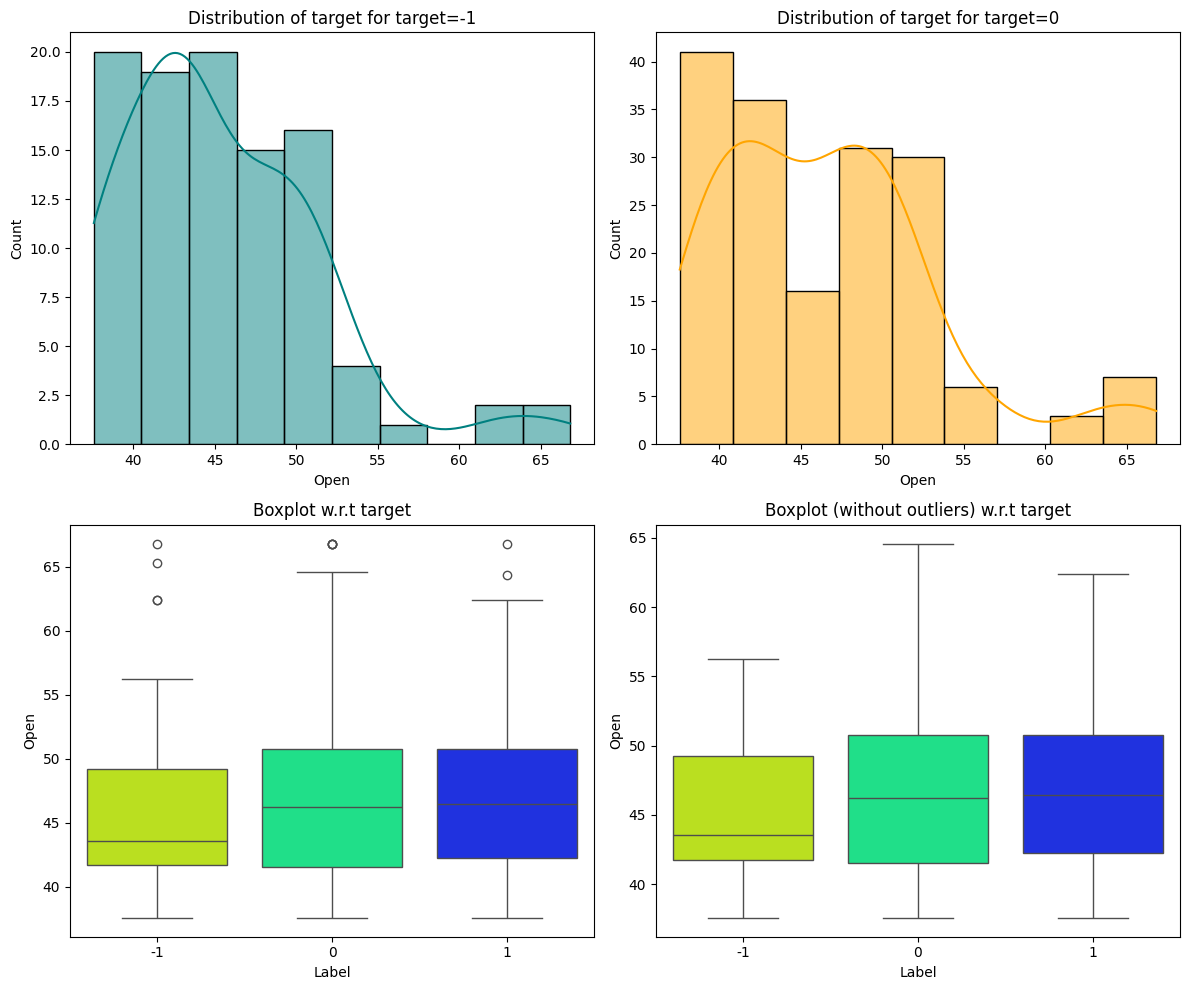

In [ ]:
distribution_plot_wrt_target(stock, "Open", "Label")

* For Label = -1 (negative sentiment), the Open prices are slightly left-skewed, with most values concentrated between 40 and 50.
* For Label = 0 (neutral sentiment), the Open prices appear more evenly distributed compared to negative sentiment, with a slight right skew and higher values extending closer to 65.
* Positive sentiment (Label = 1) shows a generally higher median Open price compared to neutral and negative sentiments, as indicated by the boxplot.
* Outliers are present in all three sentiment categories, particularly in the higher range of Open prices.
* Removing outliers does not significantly change the overall distribution across the three sentiment categories, suggesting outliers have minimal influence on the main trends.

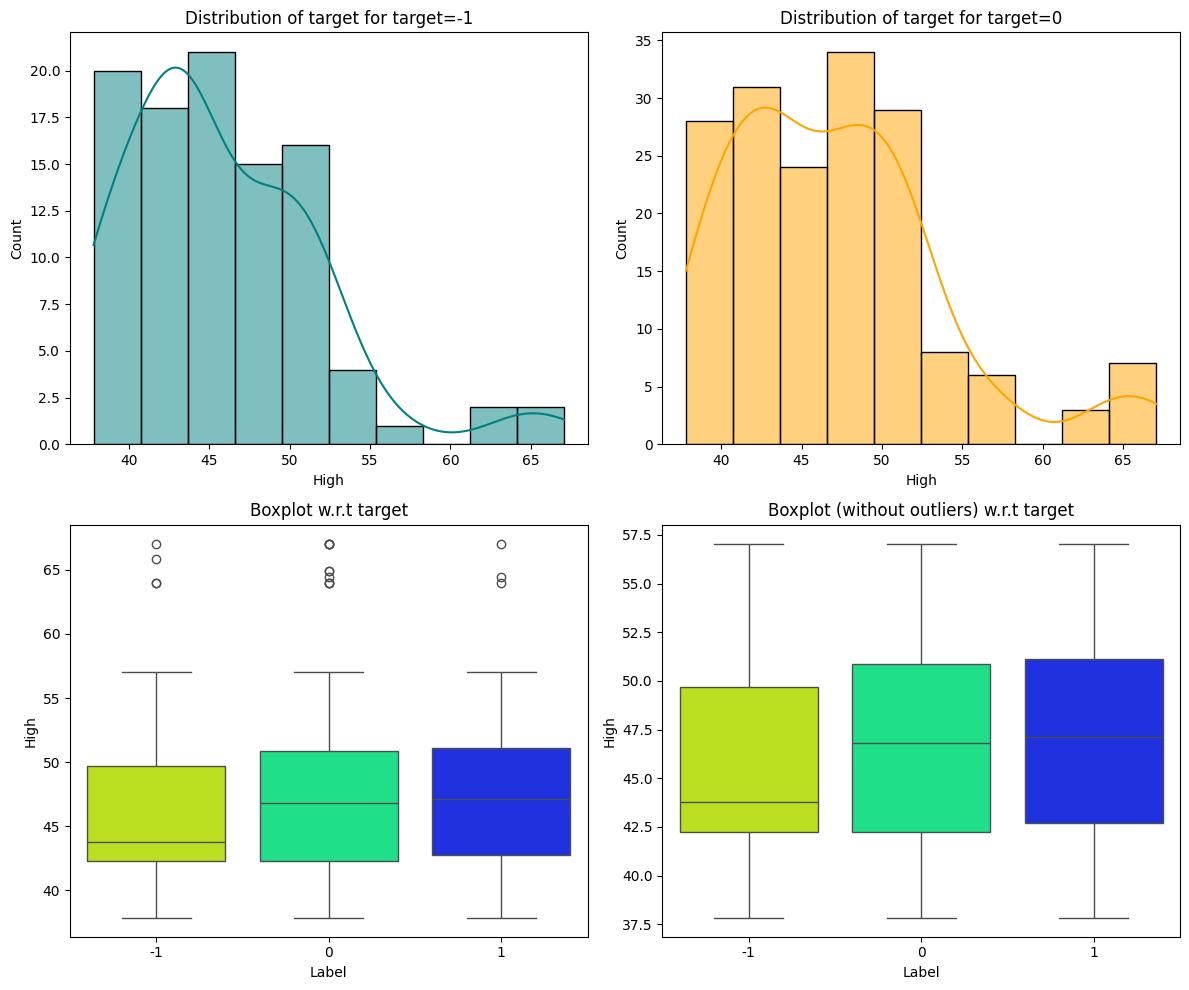

In [ ]:
distribution_plot_wrt_target(stock, "High", "Label")

* For Label = -1 (negative sentiment), the distribution of High prices is slightly left-skewed, with most values concentrated between 40 and 50, similar to the Open prices.
* For Label = 0 (neutral sentiment), the High prices are more evenly distributed with a slight right skew, and the values extend higher compared to the negative sentiment group.
* Positive sentiment (Label = 1) shows a higher median for High prices compared to neutral and negative sentiments, as depicted in the boxplots.
* Outliers in the High variable are present across all three sentiment categories, particularly in the higher range of values.
* After removing outliers, the distributions remain consistent, indicating that the High prices main trends are not significantly affected by the outliers. The positive sentiment group consistently shows higher values compared to the other sentiment categories.

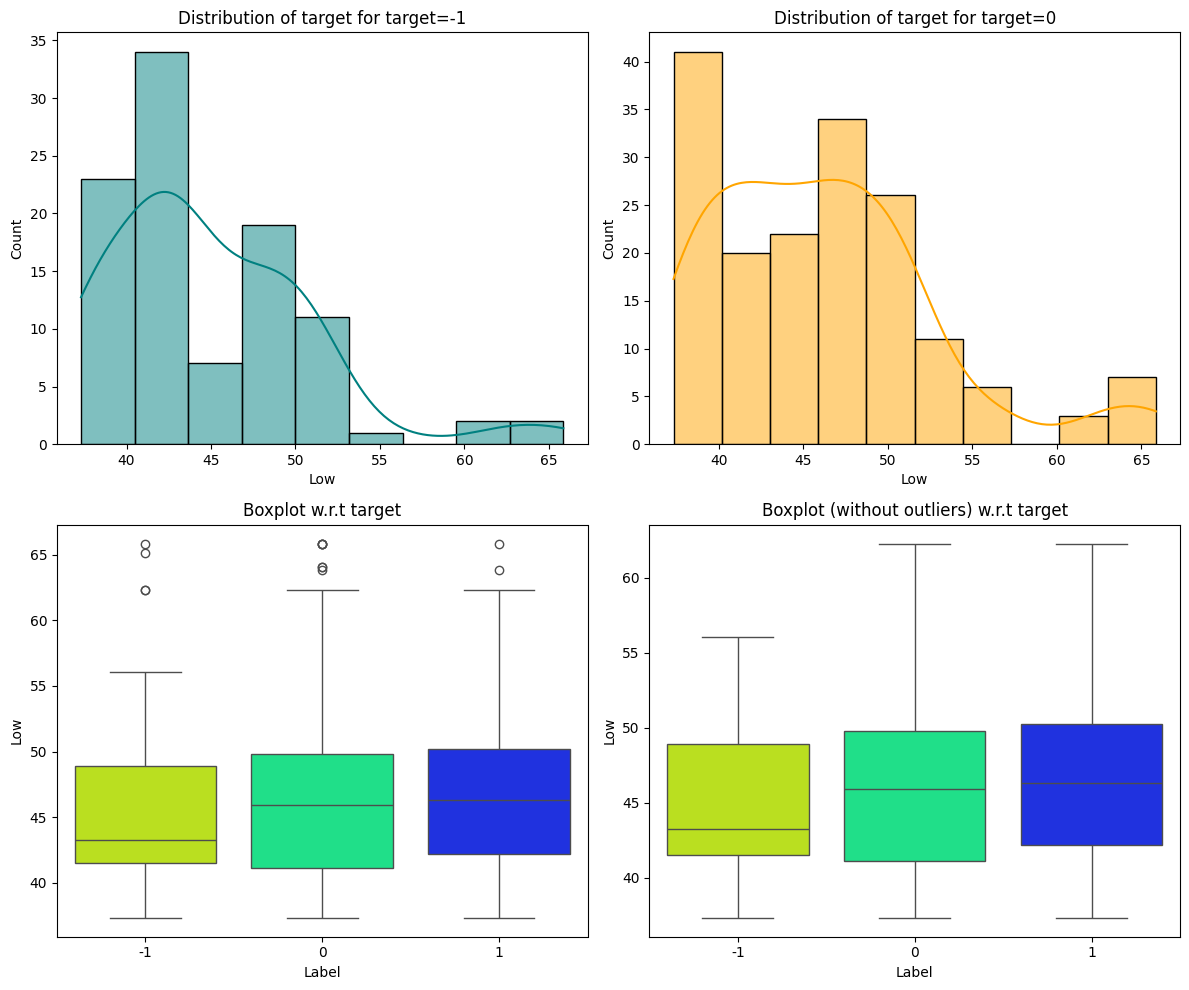

In [ ]:
distribution_plot_wrt_target(stock, "Low", "Label")

* For Label = -1 (negative sentiment), the Low prices have a distribution concentrated between 40 and 45, with fewer instances above 50. The distribution shows a left skew, indicating that lower values are more common.
* For Label = 0 (neutral sentiment), the Low prices are more evenly distributed across the range, with the peak around 45-50. The values extend slightly higher compared to the negative sentiment group.
* For Label = 1 (positive sentiment), the Low prices exhibit the highest median among the three sentiment groups, as seen in the boxplots. The positive sentiment group also has more values distributed in the higher range.
* Outliers are present across all three sentiment categories, especially for higher Low prices in the positive and neutral sentiment groups.
* After removing outliers, the boxplot shows that the spread of Low prices is slightly larger for the positive sentiment group, indicating greater variability in Low prices when sentiment is positive compared to neutral or negative sentiment.

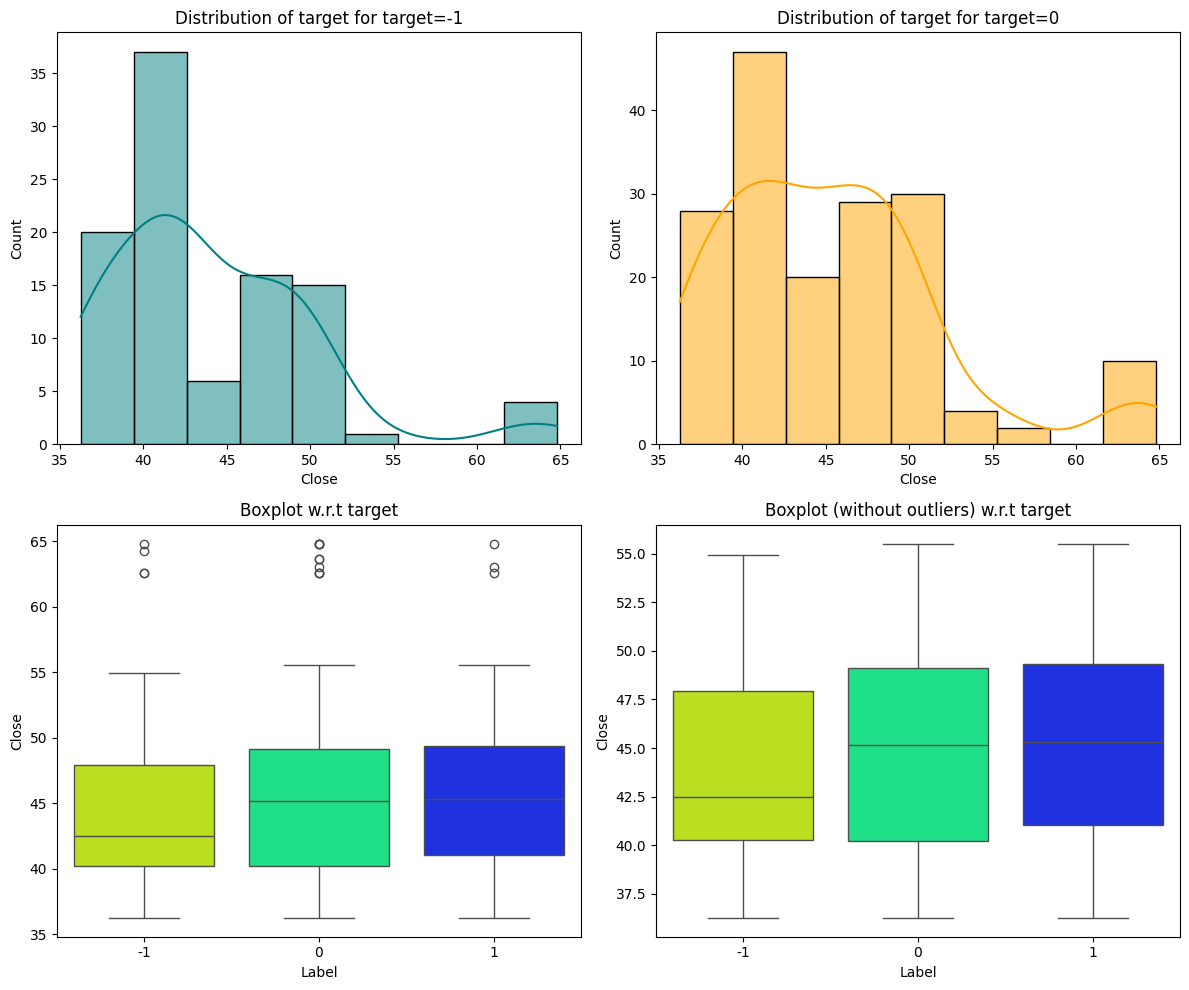

In [ ]:
distribution_plot_wrt_target(stock, "Close", "Label")

* For Label = -1 (negative sentiment), the Close prices are mostly concentrated between 40 and 45. The distribution shows a left skew, with relatively fewer occurrences of higher Close prices.
* For Label = 0 (neutral sentiment), the Close prices are spread across a wider range compared to negative sentiment. The peak is observed around 45-50, and there are more instances of higher prices compared to the negative group.
* For Label = 1 (positive sentiment), the median Close price is the highest among the three groups, as seen in the boxplots. The positive sentiment group also exhibits a broader spread, extending to higher Close prices.
* Outliers are present in all three groups, especially at the higher end of the price range. These outliers are more prominent for the positive sentiment group.
* After removing outliers, the spread of Close prices is slightly larger for the positive sentiment group, indicating that positive sentiment is associated with a broader range of Close prices compared to neutral or negative sentiment.

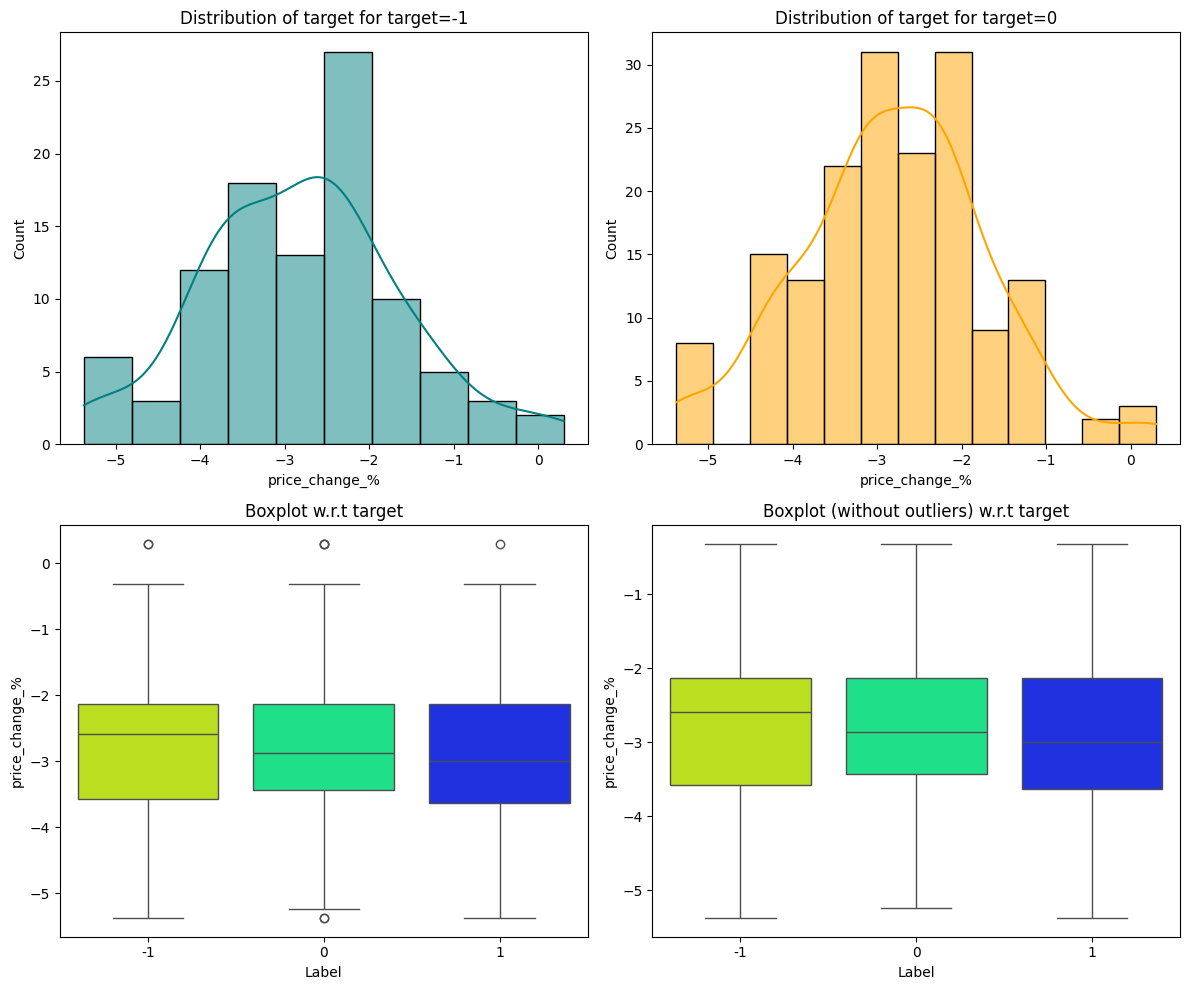

In [ ]:
distribution_plot_wrt_target(stock, "price_change_%", "Label")

* For Label = -1 (negative sentiment), the price_change_% values are concentrated between -5% and -1%. The median is around -3%, indicating a predominantly negative price movement for stocks associated with negative sentiment.
* For Label = 0 (neutral sentiment), the distribution is similar to the negative sentiment group, with values concentrated between -5% and -1%. However, the spread is slightly wider, and the median is close to -3%, indicating a stable but slightly negative price movement.
* For Label = 1 (positive sentiment), the median price_change_% is slightly closer to zero compared to the other groups, suggesting that stocks associated with positive sentiment experience less negative price change.
* The boxplots indicate that all three sentiment groups share a similar range of price_change_% values, extending from approximately -5% to near zero, with a few outliers above zero.
* The interquartile range (IQR) for positive sentiment is marginally wider than that of neutral and negative sentiment, suggesting more variability in price changes for stocks associated with positive sentiment.

#### Label vs Volume

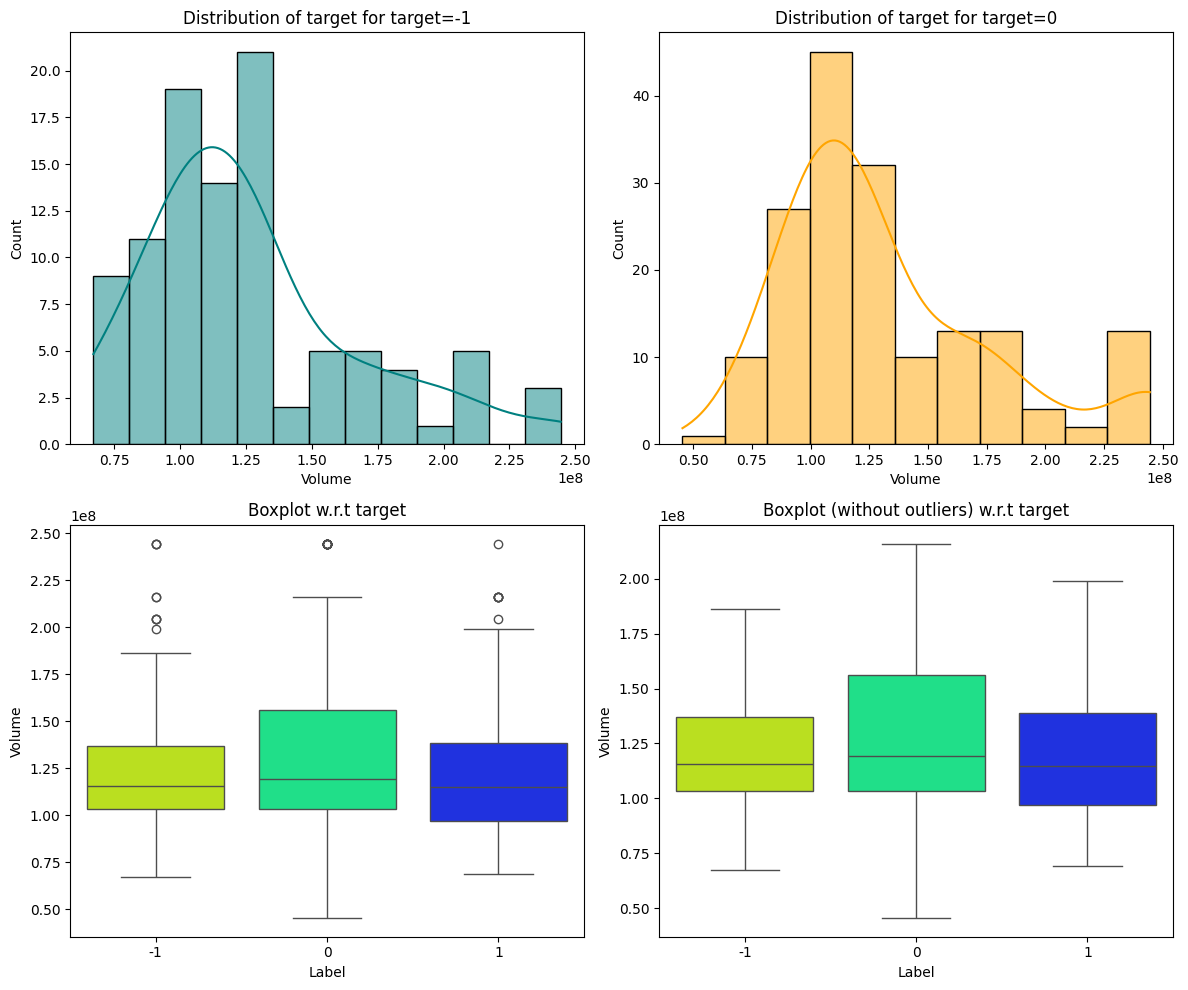

In [ ]:
distribution_plot_wrt_target(stock, "Volume", "Label")

* Negative sentiment: The volume distribution for negative sentiment is concentrated around 1.25 \times 10^8, with a slightly skewed distribution and fewer high-volume extremes compared to neutral and positive sentiments.
* Neutral sentiment: The neutral label displays the broadest volume range, with a higher median volume compared to negative and positive sentiments, indicating more frequent moderate to high trading activity.
* Positive sentiment: Positive sentiment shows a more compact volume distribution, with its median and interquartile range lower than neutral sentiment, suggesting less variability in trading activity.
* Outliers: Across all sentiment labels, there are notable high-volume outliers, particularly in neutral sentiment, which shows the highest number of extreme values.
* Variability: Neutral sentiment exhibits the highest variability in trading volume, implying that the trading activity for neutral sentiment-related days fluctuates significantly more than for positive or negative sentiment days. Across the different sentiments, however, the median volume remains around the same value so it is likely not a strong indicator of volume traded.

#### Date vs Price

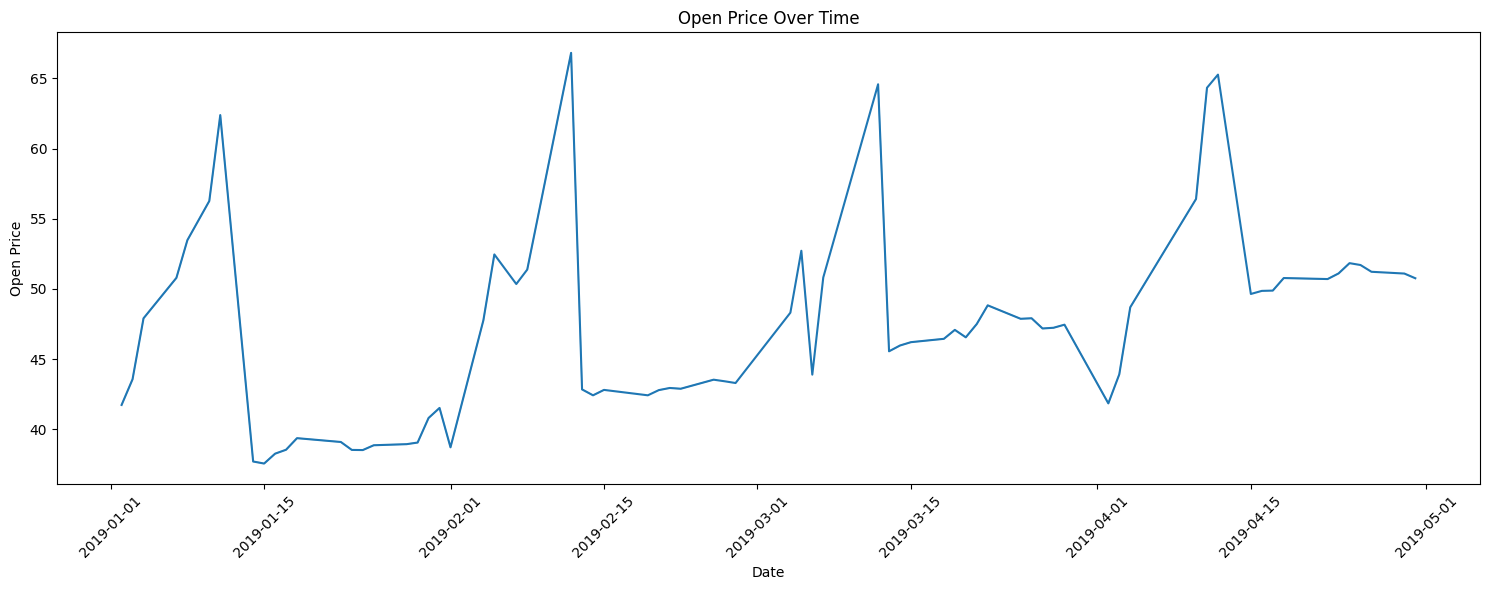

In [ ]:
sns.lineplot(data=stock, x='Date', y='Open').set(title='Open Price Over Time', xlabel='Date', ylabel='Open Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.gcf().set_size_inches(15, 6)  # Make the plot wider
plt.tight_layout()  # Adjust layout to fit labels properly
plt.show()

* The open price shows sharp spikes at regular intervals, indicating periods of high volatility in the stock market. These could correlate with significant market or company events, which may be reflected in the news headlines.
* There are noticeable dips in the open price after each spike, suggesting potential correction phases or rapid responses to earlier increases.
* Overall, the open price fluctuates between 40 & 60 dollars,  with no steady upward or downward trend over time, reflecting a dynamic market condition within this timeframe.

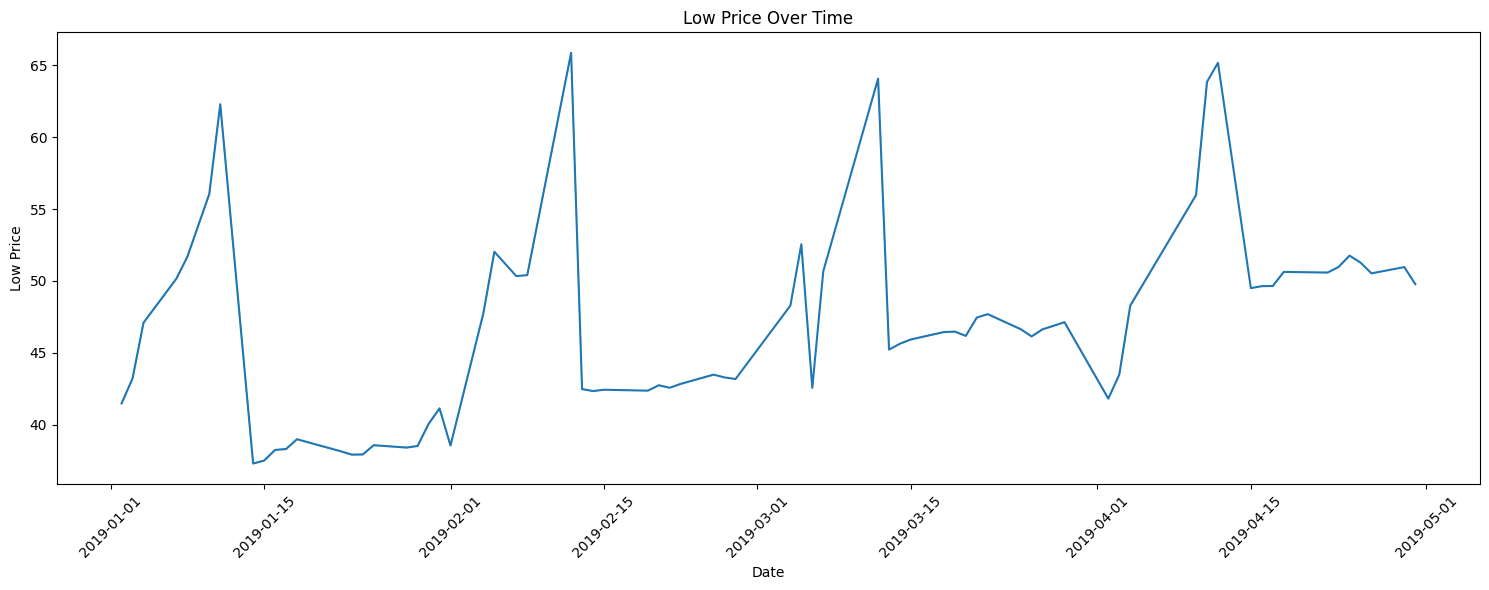

In [ ]:
sns.lineplot(data=stock, x='Date', y='Low').set(title='Low Price Over Time', xlabel='Date', ylabel='Low Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.gcf().set_size_inches(15, 6)  # Make the plot wider
plt.tight_layout()  # Adjust layout to fit labels properly
plt.show()

* The low price shows sharp spikes at regular intervals, indicating periods of high volatility in the stock market. These could correlate with significant market or company events, which may be reflected in the news headlines.
* There are noticeable dips in the open price after each spike, suggesting potential correction phases or rapid responses to earlier increases.
* Overall, the open price fluctuates between 40 & 60 dollars, with no steady upward or downward trend over time, reflecting a dynamic market condition within this timeframe.
* The trend is identical to that of opening price.

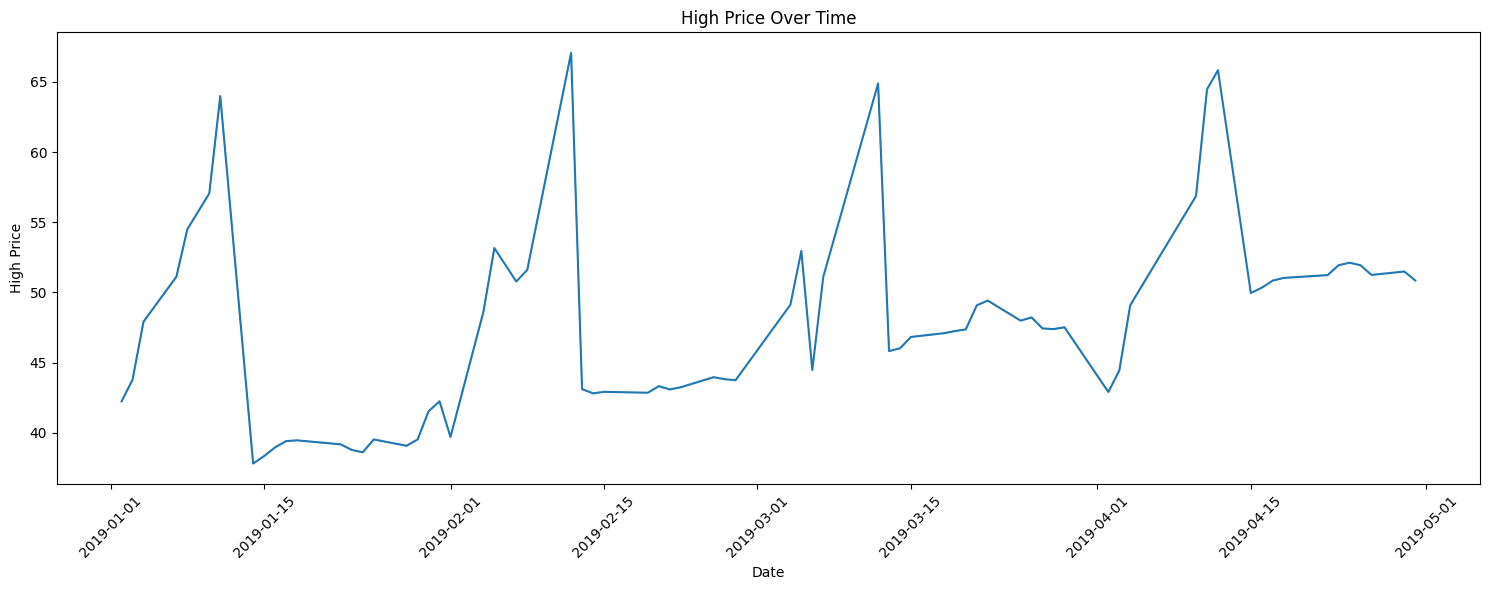

In [ ]:
sns.lineplot(data=stock, x='Date', y='High').set(title='High Price Over Time', xlabel='Date', ylabel='High Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.gcf().set_size_inches(15, 6)  # Make the plot wider
plt.tight_layout()  # Adjust layout to fit labels properly
plt.show()

* The high price over time demonstrates a pattern of significant peaks followed by steep declines, suggesting a volatile market environment.
* Spikes occur at regular intervals, indicating that specific events or announcements may have triggered temporary surges in stock prices.
* After the peaks, the high price stabilizes at a lower level, reflecting a correction phase or normalization in the stock market activity.
* The pattern is very similar to Open and Low.


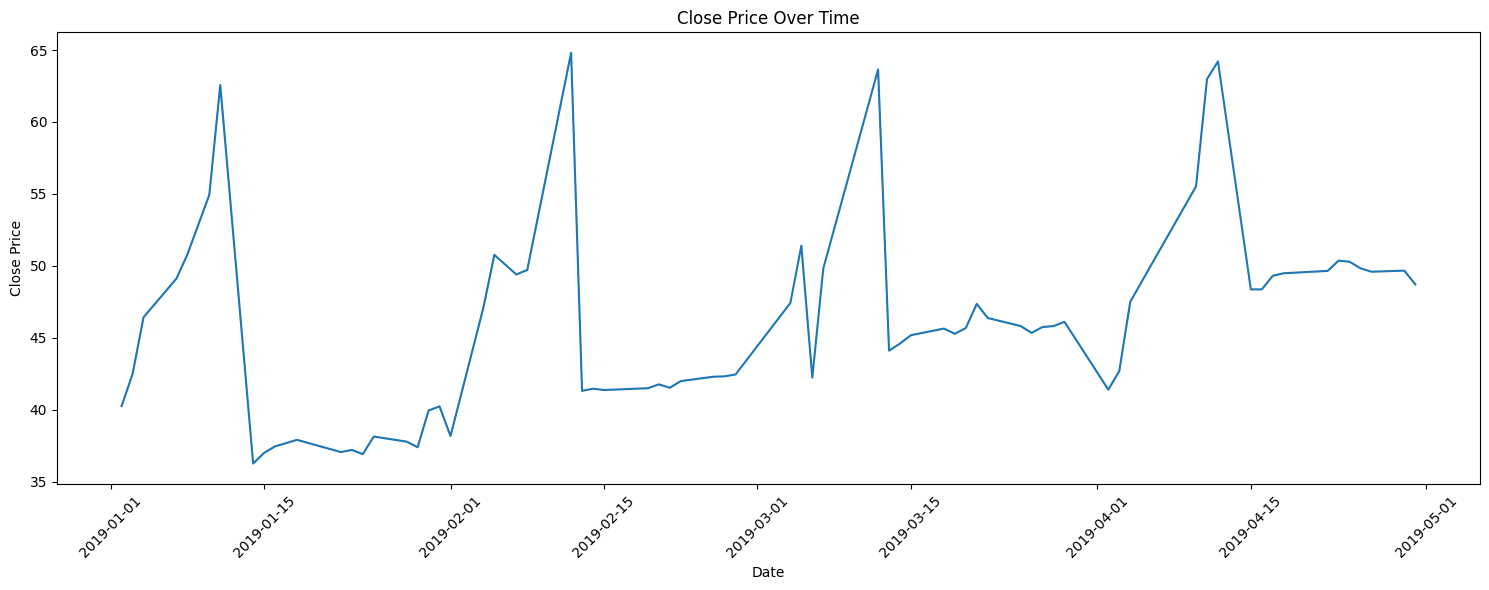

In [ ]:
sns.lineplot(data=stock, x='Date', y='Close').set(title='Close Price Over Time', xlabel='Date', ylabel='Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.gcf().set_size_inches(15, 6)  # Make the plot wider
plt.tight_layout()  # Adjust layout to fit labels properly
plt.show()

* The closing price over time mirrors the volatility of the high and open prices, with sharp peaks and troughs indicating significant price fluctuations
* Regular intervals of price surges and declines suggest the influence of periodic events or announcements impacting market sentiments.
* After the price peaks, the closing prices stabilize at lower levels, indicating corrections or adjustments post major events.
* As expected, the trend is very similar to Open, High and Low prices.

#### Volume vs Close Price

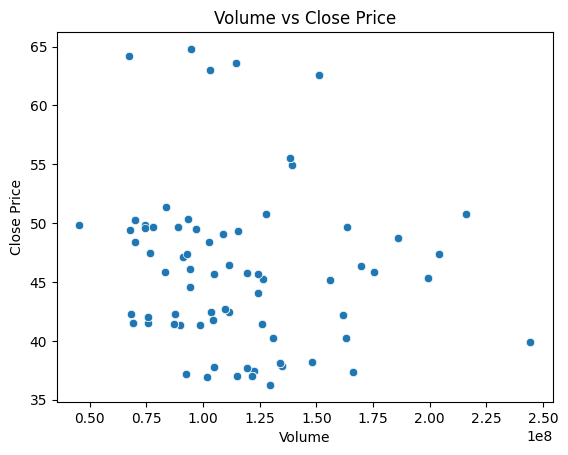

In [ ]:
# A closer look at volume and closing price
sns.scatterplot(data=stock, x='Volume', y='Close').set(title='Volume vs Close Price', xlabel='Volume', ylabel='Close Price')
plt.show()

* The scatterplot is between closing price and volume traded on that day.
* The scatterplot shows no strong linear correlation between trading volume and closing price, suggesting that price fluctuations are not consistently proportional to trading volume.
* A cluster of points is concentrated around moderate closing prices (40-50) and trading volumes (100 million to 150 million), indicating a frequent combination of these values in the dataset.
* Some outliers are visible with high trading volumes but relatively low or moderate closing prices, reflecting unique market events or anomalies.

## **Data Preprocessing**

### Remove special characters

In [ ]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [ ]:
# Applying the function to remove special characters
stock['cleaned_text'] = stock['News'].apply(remove_special_characters)

In [ ]:
# checking a couple of instances of cleaned data
stock.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,The tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,Apple lowered its fiscal Q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,Apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,This news article reports that yields on long...


### Lowercasing

In [ ]:
# changing the case of the text data to lower case
stock['cleaned_text'] = stock['cleaned_text'].str.lower()

In [ ]:
# checking a couple of instances of cleaned data
stock.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,this news article reports that yields on long...


### Remove extra whitespace


In [ ]:
# removing extra whitespaces from the text
stock['cleaned_text'] = stock['cleaned_text'].str.strip()

In [ ]:
# checking a couple of instances of cleaned data
stock.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant decl...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance t...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue for...
3,This news article reports that yields on long...,this news article reports that yields on long ...


### Remove stop words

In [ ]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [ ]:
# Applying the function to remove stop words using the NLTK library
stock['cleaned_text_without_stopwords'] = stock['cleaned_text'].apply(remove_stopwords)

In [ ]:
# checking a couple of instances of cleaned data
stock.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,the tech sector experienced a significant decl...,tech sector experienced significant decline af...
1,apple lowered its fiscal q1 revenue guidance t...,apple lowered fiscal q1 revenue guidance 84 bi...
2,apple cut its fiscal first quarter revenue for...,apple cut fiscal first quarter revenue forecas...
3,this news article reports that yields on long ...,news article reports yields long dated u treas...


### Stemming

In [ ]:
# Loading the Porter Stemmer
ps = PorterStemmer()
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [ ]:
# Applying the function to perform stemming
stock['final_cleaned_text'] = stock['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

In [ ]:
# checking a couple of instances of cleaned data
stock.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,tech sector experienced significant decline af...,tech sector experienc signific declin aftermar...
1,apple lowered fiscal q1 revenue guidance 84 bi...,appl lower fiscal q1 revenu guidanc 84 billion...
2,apple cut fiscal first quarter revenue forecas...,appl cut fiscal first quarter revenu forecast ...


The data has been processed to remove special characters, extra whitespace, stopwords, lowercasing, and stemming. These are essential to standardize and simplify text data, reducing noise and ensuring consistency.
These steps help focus on the core meaning of the text, improve model performance, and reduce computational complexity by minimizing irrelevant or redundant information.






### Test train data split

In [ ]:
# Features (X) and Target (y)
X = stock[['final_cleaned_text', 'price_change_%']]  # Include News and other predictors if needed
y = stock['Label']  # Target variable

# First split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Further split train into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

# Check sizes
print("X")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

print("Train:", y_train.value_counts())
print("Validation:", y_val.value_counts())
print("Test:", y_test.value_counts())

X
Train: (251, 2)
Validation: (45, 2)
Test: (53, 2)
Train: Label
 0    122
-1     71
 1     58
Name: count, dtype: int64
Validation: Label
 0    22
-1    13
 1    10
Name: count, dtype: int64
Test: Label
 0    26
-1    15
 1    12
Name: count, dtype: int64


The data has been split into train, test and validation, with an attempt to keep as many rows of data as possible in train in order to get the best predicting power possible within the limit dataset available.
The distribution of data between the three labels has been maintained through stratifying.

## **Word Embeddings**

In [ ]:
#Tokenization using SpaCy
# Load English tokenizer
nlp = English()

# Create a tokenizer
tokenizer = nlp.tokenizer

# Tokenize each row in the 'News' column
X_train['tokens'] = X_train['final_cleaned_text'].apply(lambda text: [token.text for token in tokenizer(text)])
X_val['tokens'] = X_val['final_cleaned_text'].apply(lambda text: [token.text for token in tokenizer(text)])
X_test['tokens'] = X_test['final_cleaned_text'].apply(lambda text: [token.text for token in tokenizer(text)])

The data is first tokenized using the English Spacy tokenizer in order to obtain tokens that can be more easily vectorized in the next steps, that provide the best meaning to the model.
The data is tokenized separately for train, validation and test datasets to avoid data leakage. This ensures that when we measure the performance on validation and test, that we can measuring performance on truly unseen data.

#### Word2Vec

In [ ]:
# Train Word2Vec Model
w2v_model = Word2Vec(sentences=X_train['tokens'], min_count=2, workers=6)

# Generate embeddings by averaging word vectors for each news headline
X_train['w2v'] = X_train['tokens'].apply(lambda x: np.mean([w2v_model.wv[word] for word in x if word in w2v_model.wv], axis=0))
X_val['w2v'] = X_val['tokens'].apply(lambda x: np.mean([w2v_model.wv[word] for word in x if word in w2v_model.wv], axis=0))
X_test['w2v'] = X_test['tokens'].apply(lambda x: np.mean([w2v_model.wv[word] for word in x if word in w2v_model.wv], axis=0))

The above code generates Word2Vec embeddings for the tokens in a separate column 'w2v' for each row.

#### GloVe

In [ ]:
# Load GloVe embeddings
glove_path = "/content/drive/MyDrive/Colab Notebooks/Project_NLP/glove.6B.100d.txt.word2vec"
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


In [ ]:
# Generate embeddings for each headline
def get_glove_embedding(tokens, embeddings, dim=100):
    vectors = [embeddings[word] for word in tokens if word in embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

X_train['glove'] = X_train['tokens'].apply(lambda x: get_glove_embedding(x, glove_embeddings))
X_val['glove'] = X_val['tokens'].apply(lambda x: get_glove_embedding(x, glove_embeddings))
X_test['glove'] = X_test['tokens'].apply(lambda x: get_glove_embedding(x, glove_embeddings))

The above code generates GloVe embeddings for the tokens in a separate column 'glove' for each row.

#### Sentence Transformer

In [ ]:
# Load pre-trained Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings for news headlines
X_train['sentence_transformer'] = X_train['final_cleaned_text'].apply(lambda x: model.encode(x))
X_val['sentence_transformer'] = X_val['final_cleaned_text'].apply(lambda x: model.encode(x))
X_test['sentence_transformer'] = X_test['final_cleaned_text'].apply(lambda x: model.encode(x))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

The above code generates Sentence Transformer embeddings for the final cleaned text in a separate column 'sentence_transformer' for each row. We used the final cleaned text and not tokens here since transformers use attention to understand the text as a whole in context.

## **Sentiment Analysis**

In the case of sentiment analysis, both false positives and false negatives are undesirable since we want to be as accurate as possible. Neither has a greater weight. Therefore, the metric used will be F1 score in order to get a balanced comparison of reducing both false positives and false negatives.
The classifier model used in this case will be the ensemble method Random Forest with the vectorized word embeddings.

In [ ]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['negative', 'neutral', 'positive']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Word2Vec Random Forest Base Model

First, we create a base model with Word2Vec embeddings and a random forest model to get a baseline performance.

In [ ]:
# Prepare data
X_train_w2v = np.vstack(X_train['w2v'].values)
X_val_w2v = np.vstack(X_val['w2v'].values)

In [ ]:
# Train Random Forest Model
rf_w2v = RandomForestClassifier(
    n_estimators=200,          # The number of trees
    class_weight='balanced',   # To handle class imbalance between neutral, positive and negative.
    random_state=42
)
# Train Model
rf_w2v.fit(X_train_w2v, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

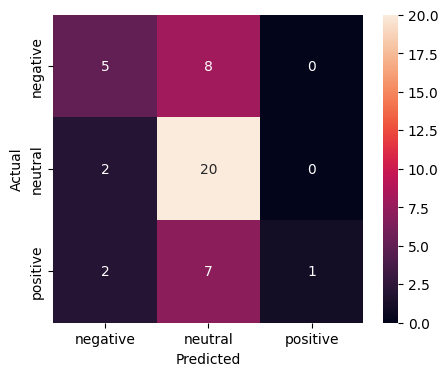

None
              precision    recall  f1-score   support

          -1       0.56      0.38      0.45        13
           0       0.57      0.91      0.70        22
           1       1.00      0.10      0.18        10

    accuracy                           0.58        45
   macro avg       0.71      0.46      0.45        45
weighted avg       0.66      0.58      0.51        45



In [ ]:
# Predict on validation set
y_val_pred_w2v = rf_w2v.predict(X_val_w2v)

# Evaluate model performance
print(plot_confusion_matrix(y_val, y_val_pred_w2v))

# Evaluate model performance
print(classification_report(y_val, y_val_pred_w2v))

In [ ]:
# F1 score on train and validation data
y_train_pred_w2v = rf_w2v.predict(X_train_w2v)
base_w2v_train = (f1_score(y_train, y_train_pred_w2v, average='weighted'))
base_w2v_val = (f1_score(y_val, y_val_pred_w2v, average='weighted'))

* The model performs best for the neutral class with a recall of 0.91, correctly predicting 20 out of 22 instances, but struggles significantly with the positive class, achieving only a recall of 0.10.
* Precision for the positive class is high at 1.00, but the low recall indicates it is overly cautious, predicting only 1 out of 10 positive instances correctly.
* The overall accuracy is 0.58, with the macro average F1-score being 0.45, showing the model has significant room for improvement, especially in handling imbalanced class predictions.
* The imbalance in data between neutral (much more data) v/s positive and negative could have an impact on the outcomes.

### GloVe Random Forest Base Model

In [ ]:
# Prepare data
X_train_glove = np.array(X_train['glove'].tolist())  # Converts the list of arrays into a 2D NumPy array
X_val_glove = np.array(X_val['glove'].tolist())      # Same for validation set

In [ ]:
# Building the model
rf_glove = RandomForestClassifier(n_estimators = 200, random_state = 42, class_weight='balanced')

# Fitting on train data
rf_glove.fit(X_train_glove, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

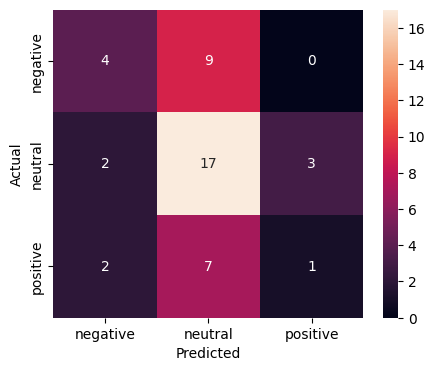

None
              precision    recall  f1-score   support

          -1       0.50      0.31      0.38        13
           0       0.52      0.77      0.62        22
           1       0.25      0.10      0.14        10

    accuracy                           0.49        45
   macro avg       0.42      0.39      0.38        45
weighted avg       0.45      0.49      0.44        45



In [ ]:
# Predict on validation set
y_val_pred_glove = rf_glove.predict(X_val_glove)

# Evaluate model performance
print(plot_confusion_matrix(y_val, y_val_pred_glove))

# Evaluate model performance
print(classification_report(y_val, y_val_pred_glove))

In [ ]:
# F1 score on train and validation data
y_train_pred_glove = rf_glove.predict(X_train_glove)
base_glove_train = (f1_score(y_train, y_train_pred_glove, average='weighted'))
base_glove_val = (f1_score(y_val, y_val_pred_glove, average='weighted'))

* The model shows better performance for the neutral class, with a recall of 0.77 (17 out of 22 correctly predicted), but struggles significantly with the positive class, achieving only a recall of 0.10 (1 out of 10).
* The negative class has a recall of 0.31, with 4 correct predictions out of 13 instances, indicating room for improvement in identifying this class.
* The overall accuracy is 0.49, with a macro average F1-score of 0.38, reflecting poor performance across all classes, especially for the positive class.
* Overall the model trained on GloVe embeddings seem to perform slightly weaker than Word2Vec embedding. The imbalance in performance metrics across the board and fairly low overall accuracy could indicate overfitting.

### Sentence Transformers Random Forest Base Model

In [ ]:
# Prepare data
X_train_st = np.array(X_train['sentence_transformer'].tolist())  # Converts the list of arrays into a 2D NumPy array
X_val_st = np.array(X_val['sentence_transformer'].tolist())      # Same for validation set

In [ ]:
# Building the model
rf_st = RandomForestClassifier(n_estimators = 200, random_state = 42, class_weight='balanced')

# Fitting on train data
rf_st.fit(X_train_st, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

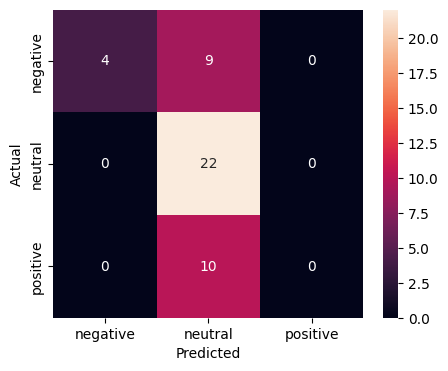

None
              precision    recall  f1-score   support

          -1       1.00      0.31      0.47        13
           0       0.54      1.00      0.70        22
           1       0.00      0.00      0.00        10

    accuracy                           0.58        45
   macro avg       0.51      0.44      0.39        45
weighted avg       0.55      0.58      0.48        45



In [ ]:
# Predict on validation set
y_val_pred_st = rf_st.predict(X_val_st)

# Evaluate model performance
print(plot_confusion_matrix(y_val, y_val_pred_st))

# Evaluate model performance
print(classification_report(y_val, y_val_pred_st))

In [ ]:
# F1 score on train and validation data
y_train_pred_st = rf_st.predict(X_train_st)
base_st_train = (f1_score(y_train, y_train_pred_st, average='weighted'))
base_st_val = (f1_score(y_val, y_val_pred_st, average='weighted'))

* The neutral class is perfectly identified, with a recall of 1.00 (all 22 instances correctly predicted), indicating the model's strong performance in this class.
* The negative class shows good precision at 1.00 but struggles with recall at 0.31 (about 4 out of 13 correctly predicted), suggesting that many negative instances are misclassified.
* The positive class is completely misclassified, with both precision and recall at 0.00, reflecting the model's inability to correctly predict any positive instances. The overall accuracy is 0.58, with a weighted F1-score of 0.48.

### Oversampling and Hyperparameter tuning

Given the imbalances in the data, it is worth exploring an oversampling technique to see if we can tackle the issue.
Along with oversampling, we are also tuning the hyperparameters using Randomized Search for each word embedding method.

In [ ]:
def apply_smote(X_train, y_train, random_state=42):
    """
    Applies SMOTE for oversampling to handle class imbalance.
    Args:
        X_train: Training features (embeddings).
        y_train: Training labels.
        random_state: Random state for reproducibility.

    Returns:
        X_resampled: Resampled features after SMOTE.
        y_resampled: Resampled labels after SMOTE.
    """
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [ ]:
# Apply SMOTE for Word2Vec
X_train_resampled_w2v, y_train_resampled_w2v = apply_smote(X_train_w2v, y_train)

# Apply SMOTE for GloVe
X_train_resampled_glove, y_train_resampled_glove = apply_smote(X_train_glove, y_train)

# Apply SMOTE for Sentence Transformer
X_train_resampled_st, y_train_resampled_st = apply_smote(X_train_st, y_train)

### Word2Vec Random Forest Tuned Model

In [ ]:
# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3,4,5,6,7,8,9,10,15,20],     # Tree depth
    'min_samples_split': [1, 2, 3, 4, 5],     # Min samples to split
    'min_samples_leaf': [1, 2],      # Min samples in a leaf node
    'class_weight': ['balanced']     # Handle class imbalance
}

In [ ]:
# Hyperparameter Tuning

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Randomized Search with 5-Fold Cross Validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    scoring='f1_macro',  # Focus on F1-score
    n_iter=50,           # Number of random combinations to test
    cv=5,                # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1            # Use all available cores
)


# Fit RandomizedSearchCV with SMOTE Resampled Data
random_search.fit(X_train_resampled_w2v, y_train_resampled_w2v)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 15, 'class_weight': 'balanced'}


In [ ]:
# Building the model
rf_w2v_smote = RandomForestClassifier(n_estimators= 300, min_samples_split= 4, min_samples_leaf= 2, max_depth= 15, random_state=42, class_weight= 'balanced')

# Fitting on train data
rf_w2v_smote.fit(X_train_resampled_w2v, y_train_resampled_w2v)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=300, random_state=42)

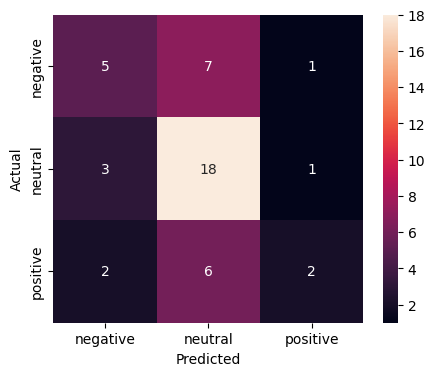

None
              precision    recall  f1-score   support

          -1       0.50      0.38      0.43        13
           0       0.58      0.82      0.68        22
           1       0.50      0.20      0.29        10

    accuracy                           0.56        45
   macro avg       0.53      0.47      0.47        45
weighted avg       0.54      0.56      0.52        45



In [ ]:
# Predict on validation set
y_val_pred_w2v_smote = rf_w2v_smote.predict(X_val_w2v)

# Evaluate model performance
print(plot_confusion_matrix(y_val, y_val_pred_w2v_smote))

# Evaluate model performance
print(classification_report(y_val, y_val_pred_w2v_smote))

In [ ]:
# F1 score on train and validation data
y_train_pred_w2v = rf_w2v_smote.predict(X_train_resampled_w2v)
tuned_w2v_train = (f1_score(y_train_resampled_w2v, y_train_pred_w2v, average='weighted'))
tuned_w2v_val = (f1_score(y_val, y_val_pred_w2v_smote, average='weighted'))

* The neutral class is predicted averagely well, with a recall of 0.82, correctly identifying 18 out of 22 instances, and an F1-score of 0.68, indicating better performance compared to the other classes.
* The negative class has balanced precision and recall at 0.50 and 0.38, respectively, with an F1-score of 0.43, showing moderate performance but room for improvement.
* The positive class has limited success, with both precision and recall at 0.50 and 0.20, respectively, resulting in an F1-score of 0.24, highlighting difficulty in predicting this class. The overall accuracy is 0.56, with a weighted F1-score of 0.52.
* At first glance there doesn't seem to be major improvements over the base model but there could be some improvement over the overfitting in the base model.

### GloVe Random Forest Tuned Model

In [ ]:
# Hyperparameter Tuning

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid Search with 5-Fold Cross Validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    scoring='f1_macro',  # Focus on F1-score for imbalance
    n_iter=50,           # Number of random combinations to test
    cv=5,                # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1            # Use all available cores
)


# Fit RandomizedSearchCV with SMOTE Resampled Data
random_search.fit(X_train_resampled_glove, y_train_resampled_glove)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 10, 'class_weight': 'balanced'}


In [ ]:
# Building the model
rf_glove_smote = RandomForestClassifier(n_estimators= 300, min_samples_split= 4, min_samples_leaf= 1, max_depth= 20, random_state=42, class_weight='balanced')

# Fitting on train data
rf_glove_smote.fit(X_train_resampled_glove, y_train_resampled_glove)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=4, n_estimators=300, random_state=42)

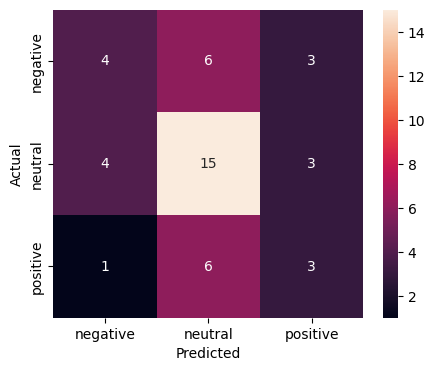

None
              precision    recall  f1-score   support

          -1       0.44      0.31      0.36        13
           0       0.56      0.68      0.61        22
           1       0.33      0.30      0.32        10

    accuracy                           0.49        45
   macro avg       0.44      0.43      0.43        45
weighted avg       0.47      0.49      0.47        45



In [ ]:
# Predict on validation set
y_val_pred_glove_smote = rf_glove_smote.predict(X_val_glove)

# Evaluate model performance
print(plot_confusion_matrix(y_val, y_val_pred_glove_smote))

# Evaluate model performance
print(classification_report(y_val, y_val_pred_glove_smote))

In [ ]:
# F1 score on train and validation data
y_train_pred_glove = rf_glove_smote.predict(X_train_resampled_glove)
tuned_glove_train = (f1_score(y_train_resampled_glove, y_train_pred_glove, average='weighted'))
tuned_glove_val = (f1_score(y_val, y_val_pred_glove_smote, average='weighted'))

* Once again, the neutral class is identified better than other classes, with a recall of 0.68 and an F1-score of 0.61, correctly predicting around 15 out of 22 instances.
* The negative class has moderate performance, with a recall of 0.31 and an F1-score of 0.36, indicating some difficulties in predicting this class.
* The positive class has lower performance, with both recall and precision around 0.30, leading to an F1-score of 0.32, reflecting challenges in distinguishing this class. Overall accuracy is 0.49, with a weighted F1-score of 0.47.
* There is no significant improvement over the base model at a glance.

### Sentence Transformers Random Forest Tuned Model

In [ ]:
# Hyperparameter Tuning

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid Search with 5-Fold Cross Validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    scoring='f1_macro',  # Focus on F1-score for imbalance
    n_iter=50,           # Number of random combinations to test
    cv=5,                # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1            # Use all available cores
)


# Fit RandomizedSearchCV with SMOTE Resampled Data
random_search.fit(X_train_resampled_st, y_train_resampled_st)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 10, 'class_weight': 'balanced'}


In [ ]:
# Building the model
rf_st_smote = RandomForestClassifier(n_estimators= 200, min_samples_split= 3, min_samples_leaf= 1, max_depth= 9, random_state=42, class_weight='balanced')

# Fitting on train data
rf_st_smote.fit(X_train_resampled_st, y_train_resampled_st)

RandomForestClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=3, n_estimators=200, random_state=42)

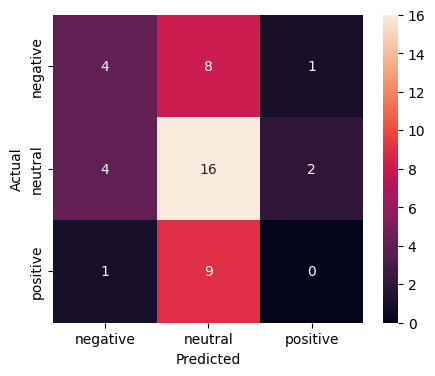

None
              precision    recall  f1-score   support

          -1       0.44      0.31      0.36        13
           0       0.48      0.73      0.58        22
           1       0.00      0.00      0.00        10

    accuracy                           0.44        45
   macro avg       0.31      0.34      0.32        45
weighted avg       0.37      0.44      0.39        45



In [ ]:
# Predict on validation set
y_val_pred_st_smote = rf_st_smote.predict(X_val_st)

# Evaluate model performance
print(plot_confusion_matrix(y_val, y_val_pred_st_smote))

# Evaluate model performance
print(classification_report(y_val, y_val_pred_st_smote))

In [ ]:
# F1 score on train and validation data
y_train_pred_st = rf_st_smote.predict(X_train_resampled_st)
tuned_st_train = (f1_score(y_train_resampled_st, y_train_pred_st, average='weighted'))
tuned_st_val = (f1_score(y_val, y_val_pred_st_smote, average='weighted'))

* The neutral class has the best recall of 0.73 and an F1-score of 0.58, correctly predicting 16 out of 22 instances, making it the strongest class performance-wise.
* The negative class shows moderate performance with a recall of 0.31 and an F1-score of 0.36, correctly identifying 4 out of 13 instances.
* The positive class performs poorly, with both recall and precision being 0.00, reflecting complete failure to predict this class. The overall accuracy is 0.44, with a weighted F1-score of 0.39.

### Model Comparison and Test Performance

In [ ]:
# Comparison of Training Performance

#Make dataframe of all metrics

models_f1_train_df = pd.DataFrame()
models_f1_train_df["Model"] = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned and Oversampled Model (Word2Vec)",
    "Tuned and Oversampled Model (GloVe)",
    "Tuned and Oversampled Model (Sentence Transformer)",
]

models_f1_train_df["F1-score"] = [base_w2v_train,
     base_glove_train,
     base_st_train,
     tuned_w2v_train,
     tuned_glove_train,
     tuned_st_train,
    ]

print("Training performance comparison:")
models_f1_train_df

Training performance comparison:


,Model,F1-score
0,Base Model (Word2Vec),1.00
1,Base Model (GloVe),1.00
2,Base Model (Sentence Transformer),1.00
3,Tuned and Oversampled Model (Word2Vec),1.00
4,Tuned and Oversampled Model (GloVe),1.00
5,Tuned and Oversampled Model (Sentence Transfor...,1.00


In [ ]:
# Comparison of Validation Performance

#Make dataframe of all metrics

models_f1_val_df = pd.DataFrame()
models_f1_val_df["Model"] = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned and Oversampled Model (Word2Vec)",
    "Tuned and Oversampled Model (GloVe)",
    "Tuned and Oversampled Model (Sentence Transformer)",
]

models_f1_val_df["F1-score"] = [base_w2v_val,
     base_glove_val,
     base_st_val,
     tuned_w2v_val,
     tuned_glove_val,
     tuned_st_val,
    ]

print("Validation performance comparison:")
models_f1_val_df

Validation performance comparison:


,Model,F1-score
0,Base Model (Word2Vec),0.51
1,Base Model (GloVe),0.44
2,Base Model (Sentence Transformer),0.48
3,Tuned and Oversampled Model (Word2Vec),0.52
4,Tuned and Oversampled Model (GloVe),0.47
5,Tuned and Oversampled Model (Sentence Transfor...,0.39


* It is observed that all the models, despite oversampling and hypertuning, are overfit on the training data.
* In the validation dataset, there is a marginal improvement in performance for Word2Vec and GloVe models with the tuning and oversampling (improvement from 0.51 to 0.52 and 0.44 to 0.47 respectively)
* In the validation dataset, tuning and oversampling has reduced the performance from 0.48 to 0.39.
* Unfortunately all the models are overfit. There is a problem of learning the noise too closely and not generalizing well enough. The dataset could benefit from more variety and not too many specific cases. The size of the dataset is also very small for the task at hand.
* Given all these limitations, the best model within the circumstances in the tuned and oversampled model using Word2Vec word embeddings.

Test performance for the final model:



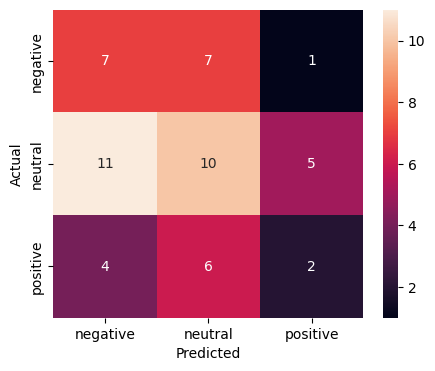

None
              precision    recall  f1-score   support

          -1       0.32      0.47      0.38        15
           0       0.43      0.38      0.41        26
           1       0.25      0.17      0.20        12

    accuracy                           0.36        53
   macro avg       0.33      0.34      0.33        53
weighted avg       0.36      0.36      0.35        53



In [ ]:
#Performance on test data
print("Test performance for the final model:\n")
X_test_w2v = np.vstack(X_test['w2v'].values)
# Predict on test set
y_test_pred = rf_w2v_smote.predict(X_test_w2v)

# Evaluate model performance
print(plot_confusion_matrix(y_test, y_test_pred))

# Evaluate model performance
print(classification_report(y_test, y_test_pred))

* The negative class performs moderately well, with a recall of 0.47 and an F1-score of 0.38, correctly identifying 7 out of 15 instances. However, precision is relatively low at 0.32, indicating a high false positive rate.
* The neutral class has the highest support with 26 instances, but its recall of 0.38 and F1-score of 0.41 indicate moderate performance, with 10 instances correctly predicted and significant confusion with other classes.
* The positive class has the weakest performance, with a recall of 0.17 and an F1-score of 0.20, correctly predicting only 2 out of 12 instances, showing significant room for improvement. The overall accuracy is 0.36, with weighted averages for F1-score and recall also at 0.36.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# For downloading the models from HF Hub
!pip install huggingface_hub datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.3 MB/s eta 0:00:00


In [4]:
!pip install llama-cpp-python --upgrade -q
!pip show llama-cpp-python

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Name: llama_cpp_python
Version: 0.3.6
Summary: Python bindings for the llama.cpp library
Home-page: https://github.com/abetlen/llama-cpp-python
Author: 
Author-email: Andrei Betlen <abetlen@gmail.com>
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: diskcache, jinja2, numpy, typing-extensions
Required-by: 


In [1]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --upgrade -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 MB 28.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for llama-cpp-python (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llama-cpp-python
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (llama-cpp-python)


In [5]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [6]:
# Loading data from Google Drive again
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
stock_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_NLP/stock_news.csv")

In [8]:
data = stock_news.copy()

#### Loading the model

Loading Llama 2 model from Hugging Face

In [9]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [10]:
model_path = hf_hub_download(
    repo_id="TheBloke/Llama-2-13B-chat-GGUF",
    filename="llama-2-13b-chat.Q5_K_M.gguf"
)

print("Model Path:", model_path)

Model Path: /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf


In [11]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,
    n_batch=256,
    n_gpu_layers=43,
    n_ctx=8000,  # Context window
    verbose=True,
)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

#### Aggregating the data weekly

In [12]:
# Convert Date column to DateTime format in order to aggregate
data["Date"] = pd.to_datetime(data['Date'])

In [13]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [14]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()
print(weekly_grouped.shape)

(18, 2)


The grouped data has two columns, the date and the concatenated news headlines per week

In [15]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [16]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [17]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [18]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = lcpp_llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=2000, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0, #Complete the code to set the value for temperature.
      top_p=0.95, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]
    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

Testing the prompt with just the first row of data, i.e. the first week's news headlines.

In [19]:
# First row
data_2 = data_1.iloc[0:1]

In [20]:
data_2

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...


##### Checking the model output on the weekly data

In [21]:
%%time
instruction_1 = """ You are an expert data analyst specializing in summarizing and categorizing news content.

Task: Analyze the provided news headlines and follow the instructions below.

Instructions:
	1.	Carefully read the list of news headlines provided.
	2.	Identify exactly three positive and three negative events from the headlines.
	3.	Summarize each selected headline into less than 10 words.
	4.	Present the output in the following JSON format, strictly adhering to the structure:

{
“positive”: {
“1”: “Summarized positive headline 1.”,
“2”: “Summarized positive headline 2.”,
“3”: “Summarized positive headline 3.”
},
“negative”: {
“1”: “Summarized negative headline 1.”,
“2”: “Summarized negative headline 2.”,
“3”: “Summarized negative headline 3.”
}
}
	5.	Ensure the JSON only contains the required keys and values with no additional text.

Example Input Headlines:
	•	“The tech sector experienced a significant decline.”
	•	“Sprint and Samsung plan to release 5G smartphones.”

Example Output:
{
“positive”: {
“1”: “Sprint to launch 5G smartphones with Samsung.”,
“2”: “EU court rules Apple must pay back taxes.”,
“3”: “US opposes France’s digital services tax.”
},
“negative”: {
“1”: “Tech sector faces significant declines.”,
“2”: “Caterpillar reports lower-than-expected earnings.”,
“3”: “Apple shares drop after Q1 revenue warning.”
}
}

Key Points to Note:
	•	The output must only contain the JSON object—no commentary or explanations.
	•	Summaries should avoid repetitions and focus on key facts.
"""
output = response_mistral_1(instruction_1, data_2['News'])

llama_perf_context_print:        load time =   87437.19 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   523 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   273 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  285581.47 ms /   796 tokens


CPU times: user 23min 16s, sys: 325 ms, total: 23min 17s
Wall time: 4min 45s


In [22]:
output

' Sure, I can help you with that! Here\'s the analysis of the provided news headlines:\n\n{\n"positive": {\n"1": "Sprint to launch 5G smartphones with Samsung.",\n"2": "EU court rules Apple must pay back taxes.",\n"3": "US opposes France\'s digital services tax."\n},\n"negative": {\n"1": "Tech sector faces significant declines.",\n"2": "Caterpillar reports lower-than-expected earnings.",\n"3": "Apple shares drop after Q1 revenue warning."\n}\n}\n\nHere are the three positive and three negative events from the headlines:\n\nPositive:\n\n1. Sprint to launch 5G smartphones with Samsung.\n2. EU court rules Apple must pay back taxes.\n3. US opposes France\'s digital services tax.\n\nNegative:\n\n1. Tech sector faces significant declines.\n2. Caterpillar reports lower-than-expected earnings.\n3. Apple shares drop after Q1 revenue warning.\n\nEach selected headline has been summarized into less than 10 words, as requested.'

In [23]:
data_2

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...


Creating a loop to process each row in the data to process the news headlines per week, calling the Llama model once per week.

In [ ]:
%%time
# Initialize an empty list to store the results
key_events = []

# Loop through each row in the DataFrame
for index, row in data_2.iterrows():
    print(f"Processing row {index+1} of {len(data_2)} of the week {row['Date']}")  #progress tracker
    # Apply the response function to the 'News' column
    result = response_mistral_1(instruction_1, row['News'])
    key_events.append(result)  # Store the result

# Add the results as a new column in the DataFrame
data_2['Key Events'] = key_events

Processing row 1 of 1 of the week 2019-01-06 00:00:00


Llama.generate: 4539 prefix-match hit, remaining 1 prompt tokens to eval


In [ ]:
data_2

##### Formatting the model output

## **Conclusions and Recommendations**

* The conjecture that the open and closing stock prices and volume traded is impacted by the major news headlines of the week are explored in this project. From the correlation, the exploratory analysis and the model building, we can conclude that this relationship is weak if any.
* Given the weak performance of classification models, an attempt should be made to collect a lot more data of news headlines in order to be able to generalize rather than learn specific instances.
* Transfer Learning can be used to take advantage of existing sentiment classification models out there to then fine tune to our use case.

<font size=6 color='blue'>Power Ahead</font>
___